Contributors: Thomas Asikis, Lucas Bottcher
## Imports

In [201]:
.%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import torch
from neural_control.controllers import DualFullyConnectedRegressionControllerCompressed, imitatation_learn
from neural_control.dynamics import DualSourcingModel
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from plotly import graph_objects as go
from sourcing_models.utilities import sample_trajectories_capped_dual_index, \
sample_trajectories_dual_index, sample_trajectories_single_index, sample_trajectories_tailored_base_surge
import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
#import seaborn as sns

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
# tell matplotlib about your params
rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sourcing Problem Parameters

In [202]:
sourcing_parameters = dict(ce=20,
                           cr=0,
                           le=0,
                           lr=2,
                           h=5,
                           b=95,
                           T=100)

## NNC Initialization
Here we initialize an NNC model and set  its hyperparameters for training.

In [203]:
### One can experiment with different layer architectures and activations per layer
nnc_hyperparameters = dict(
    n_hidden_units = [64,32,16,8,4]
)

### We use celu non-linearities for the input layer, hidden layers, and output layer
nnc_hyperparameters['n_activations'] = [torch.nn.CELU(alpha=1)]*(2 + len(nnc_hyperparameters['n_hidden_units']))


fcc = DualFullyConnectedRegressionControllerCompressed(lr=sourcing_parameters['lr'], 
                                         le=sourcing_parameters['le'], 
                                         n_hidden_units= nnc_hyperparameters ['n_hidden_units'],
                                         activations=nnc_hyperparameters['n_activations']
                                        ) # controller neural network object


## Dynamics Initialization
To further optimize NNC (''fine tuning''), we now apply gradient propagation to the inventory evolution equation:

$I_t = I_{t-1} + q^{\rm e}_{t-l_{\rm e}} + q^{\rm r}_{t-l_{\rm r}} - D_t$

where $I_0, q^{\rm e}_{t},q^{\rm r}_{t}$ are NNC outputs.

In [204]:
dsd = DualSourcingModel(fcc, I_0=6, **sourcing_parameters) # Dual Sourcing Dynamics object

We preserve the best performing model in training, assuming that the neural network generalizes well during training and that our training sample is large enough.

In [205]:
best_loss = [np.infty]
best_model = [None]

In [206]:
all_training_costs = []

We observe that we have a neural network that outputs $q^{\rm r}_{t-l_{\rm r}}, q^{\rm e}_{t-l_{\rm e}}$ given the input described above.
The initial inventory $I_0$ is independent of inputs and can be learned separately (in a way that is similar to learning a bias term of a neural network).
We use separate optimizers to learn order quantities and initial inventory.
This may create learning variance, as one optimizer may overfit on a value that is directly changed by another optimizer. 
To reduce the learning variance, we let the order optimizer operate on 7 out of 10 learning epochs and the inventory optimizer on the remaining epochs.

In [207]:
optimizer = torch.optim.RMSprop(#[dsd.I_0],
                                list(fcc.parameters()), 
                                lr=3*1e-3
                               )
optimizer2 = torch.optim.RMSprop([dsd.I_0],
                                #list(fcc.parameters()), 
                                lr=1e-1
                               )

We now fine tune the model after imitation, in order to generalize and hopefully outperform the method used to train the model.
To do so, we repetively train and fine tune the parameters of 128 trajectories generated by setting a specific random seed. We do not resample new trajectories, as we want the network to overfit on the process. Sampling new samples could increase the input variance, and could potentially slow/prohibit convergence.

In [208]:
fine_tuning_iterations = 3000
minibatch_size = 256
random_seed = 4

t0 = time.time()
for it in range(fine_tuning_iterations):
    optimizer.zero_grad()
    optimizer2.zero_grad()
    def closure():
        dsd.reset(minibatch_size, seed=random_seed+1)
        total_costs = 0
        for i in range(dsd.T):
            current_costs, demands, current_inventories, qr, qra, qe, qea = dsd.simulate()
            total_costs = current_costs.mean() + total_costs
        all_training_costs.append(float(total_costs)/dsd.T)
        total_costs.backward()
        if it % 20 == 0:
            print(total_costs/dsd.T)
        if total_costs < best_loss[0]:
            best_loss[0] = total_costs.detach().cpu().item()
            best_model[0] = deepcopy(fcc.state_dict())
        return total_costs
    #if it > 1 and all_training_costs[-1] <= 26.4:
    #        break
    if it % 10 > 6:
        optimizer2.step(closure)
    else:
        optimizer.step(closure)
t1 = time.time()
total = t1-t0
print(total)

tensor(7827.8911, grad_fn=<DivBackward0>)
tensor(83.4521, grad_fn=<DivBackward0>)
tensor(36.7682, grad_fn=<DivBackward0>)
tensor(32.4123, grad_fn=<DivBackward0>)
tensor(32.6287, grad_fn=<DivBackward0>)
tensor(32.4723, grad_fn=<DivBackward0>)
tensor(32.5252, grad_fn=<DivBackward0>)
tensor(32.4559, grad_fn=<DivBackward0>)
tensor(31.8055, grad_fn=<DivBackward0>)
tensor(31.2885, grad_fn=<DivBackward0>)
tensor(31.6111, grad_fn=<DivBackward0>)
tensor(31.6803, grad_fn=<DivBackward0>)
tensor(30.0725, grad_fn=<DivBackward0>)
tensor(31.3977, grad_fn=<DivBackward0>)
tensor(31.9830, grad_fn=<DivBackward0>)
tensor(27.8125, grad_fn=<DivBackward0>)
tensor(28.1354, grad_fn=<DivBackward0>)
tensor(27.1096, grad_fn=<DivBackward0>)
tensor(26.5137, grad_fn=<DivBackward0>)
tensor(25.4670, grad_fn=<DivBackward0>)
tensor(25.9162, grad_fn=<DivBackward0>)
tensor(26.7709, grad_fn=<DivBackward0>)
tensor(26.0338, grad_fn=<DivBackward0>)
tensor(25.5857, grad_fn=<DivBackward0>)
tensor(25.3719, grad_fn=<DivBackward0>

KeyboardInterrupt: 

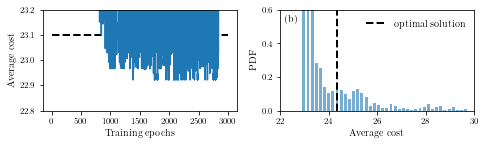

In [209]:
from matplotlib.ticker import NullFormatter

# set nice figure sizes
fig_width_pt = 495    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, 0.5*fig_height]
rcParams.update({'figure.figsize': fig_size})

costs = np.array(all_training_costs)
#np.savetxt("cost_direct_learning.dat",costs)

fig, ax = plt.subplots(ncols=2)
#ax[0].text(0.02*3000,0.88*(23.5-23)+23,r"(a)")
ax[0].plot(costs,alpha=1)
ax[0].hlines(23.1,0,3000,linewidths=2,colors="k",linestyles="--")
#ax[0].set_xlim(0,3000)
ax[0].set_ylim(22.8,23.2)
ax[0].yaxis.set_minor_formatter(NullFormatter())
ax[0].set_xlabel(r'Training epochs')
ax[0].set_ylabel(r'Average cost')

ax[1].text(0.02*(30-22)+22,0.88*0.6,r"(b)")
ax[1].hist(costs[costs <= 30],bins=40,density=True,width=0.12,alpha=0.6)
ax[1].vlines(24.33,0,1,linewidths=2,colors="k",linestyles="--",label="optimal solution")
ax[1].set_yticks([0,0.2,0.4,0.6])
ax[1].set_xlabel(r'Average cost')
ax[1].set_ylabel(r'PDF')
ax[1].set_xlim(22,30)
ax[1].set_ylim(0,0.6)
ax[1].legend(loc=1,frameon=False)
plt.tight_layout()
plt.margins(0,0)
plt.savefig("training_dual_index.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

In [210]:
min(costs)

22.921875

The above learning curve can be used to monitor learning.

After successful fine tuning we load the best performing model during training.

In [211]:
#best_model_load = torch.load('nnc_best_model_direct_lr=4_ce=10.pt', map_location='cpu')
#print(best_model_load)
#fcc.load_state_dict(best_model_load)
fcc.load_state_dict(best_model[0])

<All keys matched successfully>

We often train for $T=50$, but to study the ability of the model to generalize we report the average costs per timestep for $2048$ new samples and $T' = 1000$

In [214]:
fine_tuning_iterations = 1

for it in range(fine_tuning_iterations):

    dsd.reset(1024)
    total_costs = 0
    for i in range(dsd.T*10):
        current_costs, demands, current_inventories, qr, qra, qe, qea = dsd.simulate()
        total_costs = current_costs.mean() + total_costs
    if it % 1 == 0:
        print('Reported mean cost per timestep is: ' + str(total_costs.item()/(dsd.T*10)))

Reported mean cost per timestep is: 22.849169921875


In [212]:
torch.save(best_model[0], 'nnc_best_model_direct_lr=4_ce=10_95_5_Jul2621_64layer_256batch.pt')

In [13]:
#dsd.learned_I_0.detach().clone()[0]

## Comparison 
First, we generate new dual-index samples.
These will be used to compare performance on unseen samples for NNC.

In [15]:
sourcing_parameters = dict(ce=10,
                           cr=0,
                           le=0,
                           lr=4,
                           h=5,
                           b=495,
                           T=1000,
                           I0=4)

state_trajectories, qr_trajectories, qe_trajectories =\
    sample_trajectories_capped_dual_index(n_trajectories=1000, seed=25, **sourcing_parameters)

minimum cost: 20.9795
u1*: 4
u2*: 12
u3*: 2


In [16]:
dsd.reset(1)
def evaluate_nnc_on_sample(state_trajectories, 
                           sample_id):
    
    fixed_demands = state_trajectories[sample_id, 1:, 1].unsqueeze(-1)

    nn_inv = dsd.learned_I_0.detach().clone()
    dsd.reset(1)
    nn_qr = [torch.zeros([1,1])]*(dsd.lr+1)
    nn_qe = [torch.zeros([1,1])]*(dsd.le+1)
    nn_ci = []
    all_nn_inv = [nn_inv.item()]
    D = torch.tensor(0.0).unsqueeze(0).unsqueeze(0)
    for i in range(sourcing_parameters["T"]):
        qr, qe = fcc(D, nn_inv, nn_qr, nn_qe)
        D = fixed_demands[i].unsqueeze(0)
        nn_qr.append(qr)
        nn_qe.append(qe)
        qra = nn_qr[-dsd.lr-1]
        qea = nn_qe[-dsd.le-1]
        c_i, nn_inv = dsd.replay_step(nn_inv, D, qra, qea, qr, qe)
        nn_ci.append(c_i)
        all_nn_inv.append(nn_inv.item())
    return all_nn_inv, nn_qr, nn_qe, nn_ci, torch.stack(nn_ci).mean()

In [17]:
def evaluate_cdi_on_sample(state_trajectories, 
                           qr_trajectories, 
                           qe_trajectories, 
                           sample_id):
    
    dsd.reset(1)
    fixed_demands = state_trajectories[sample_id, 1:, 1].unsqueeze(-1)

    ds_inv = state_trajectories[sample_id, 0, 0].unsqueeze(0).unsqueeze(0)
    dsd.reset(1)
    all_qr = [0]*dsd.lr
    all_qe = [0]*dsd.le
    all_ci = []
    all_inv = [ds_inv.detach().item()]
    for i in range(sourcing_parameters["T"]):
        D = fixed_demands[i].unsqueeze(0)
        if dsd.le == 0:
            qe = qe_trajectories[sample_id, i+1]
        else:
            qe = qe_trajectories[sample_id, dsd.le+i]
    
        if dsd.lr == 0:
            qr = qr_trajectories[sample_id, i+1]
        else:
            qr = qr_trajectories[sample_id, dsd.lr+i]
            
        all_qr.append(qr)
        all_qe.append(qe)
        qra = all_qr[-dsd.lr-1]
        qea = all_qe[-dsd.le-1]
        c_i, ds_inv = dsd.replay_step(ds_inv, D, qra, qea, qr, qe)
        all_inv.append(ds_inv.detach().item())
        all_ci.append(c_i)
    # test if calculated inventories and costs are the same as the ones reported
    # from the dual sourcing code
    assert torch.all(torch.tensor(all_inv) == state_trajectories[sample_id, :, 0])
    assert torch.all(torch.tensor(all_ci) == state_trajectories[sample_id, 1:, -1])
    return all_inv, all_qr, all_qe, all_ci, torch.stack(all_ci).mean()

In [18]:
cost_ratios = []
cost_nn = []
cost_cdi = []

samples = 500
for i in range(samples):
    print("%d/%d samples completed"%(i,samples))
    nn_inv, nn_qr, nn_qe, nn_ci, nn_mean_cost = evaluate_nnc_on_sample(state_trajectories, 
                                                                       i)
    
    cdi_inv, cdi_qr, cdi_qe, cdi_ci, cdi_mean_cost = evaluate_cdi_on_sample(state_trajectories, 
                                                                            qr_trajectories, 
                                                                            qe_trajectories, 
                                                                            i)
    cost_nn.append(nn_mean_cost.detach().item())
    cost_cdi.append(cdi_mean_cost.detach().item())
    cost_ratios.append(nn_mean_cost.detach().item()/cdi_mean_cost.detach().item())

0/500 samples completed
1/500 samples completed
2/500 samples completed
3/500 samples completed
4/500 samples completed
5/500 samples completed
6/500 samples completed
7/500 samples completed
8/500 samples completed
9/500 samples completed
10/500 samples completed
11/500 samples completed
12/500 samples completed
13/500 samples completed
14/500 samples completed
15/500 samples completed
16/500 samples completed
17/500 samples completed
18/500 samples completed
19/500 samples completed
20/500 samples completed
21/500 samples completed
22/500 samples completed
23/500 samples completed
24/500 samples completed
25/500 samples completed
26/500 samples completed
27/500 samples completed
28/500 samples completed
29/500 samples completed
30/500 samples completed
31/500 samples completed
32/500 samples completed
33/500 samples completed
34/500 samples completed
35/500 samples completed
36/500 samples completed
37/500 samples completed
38/500 samples completed
39/500 samples completed
40/500 sam

In [19]:
(np.array(cost_ratios) < 1).sum()/len(cost_ratios)

0.962

In [340]:
print(cost_nn[:20],np.mean(cost_nn))
print(cost_cdi[:20],np.mean(cost_cdi))

[17.03499984741211, 16.90999984741211, 16.799999237060547, 16.80500030517578, 16.575000762939453, 17.110000610351562, 17.149999618530273, 16.854999542236328, 17.065000534057617, 17.510000228881836, 16.864999771118164, 16.895000457763672, 16.704999923706055, 17.084999084472656, 16.895000457763672, 16.584999084472656, 16.950000762939453, 17.329999923706055, 17.2450008392334, 16.704999923706055] 16.873139995574952
[17.040000915527344, 16.934999465942383, 16.844999313354492, 16.844999313354492, 16.6200008392334, 17.079999923706055, 17.2450008392334, 16.864999771118164, 17.094999313354492, 17.829999923706055, 16.8700008392334, 16.954999923706055, 16.684999465942383, 17.139999389648438, 16.950000762939453, 16.55500030517578, 16.915000915527344, 17.360000610351562, 17.280000686645508, 16.684999465942383] 16.890830017089844


In [341]:
np.mean(cost_ratios)

0.9989698991289299

Below we plot the distribution of the mean cost per step ratio between NNC and DI.

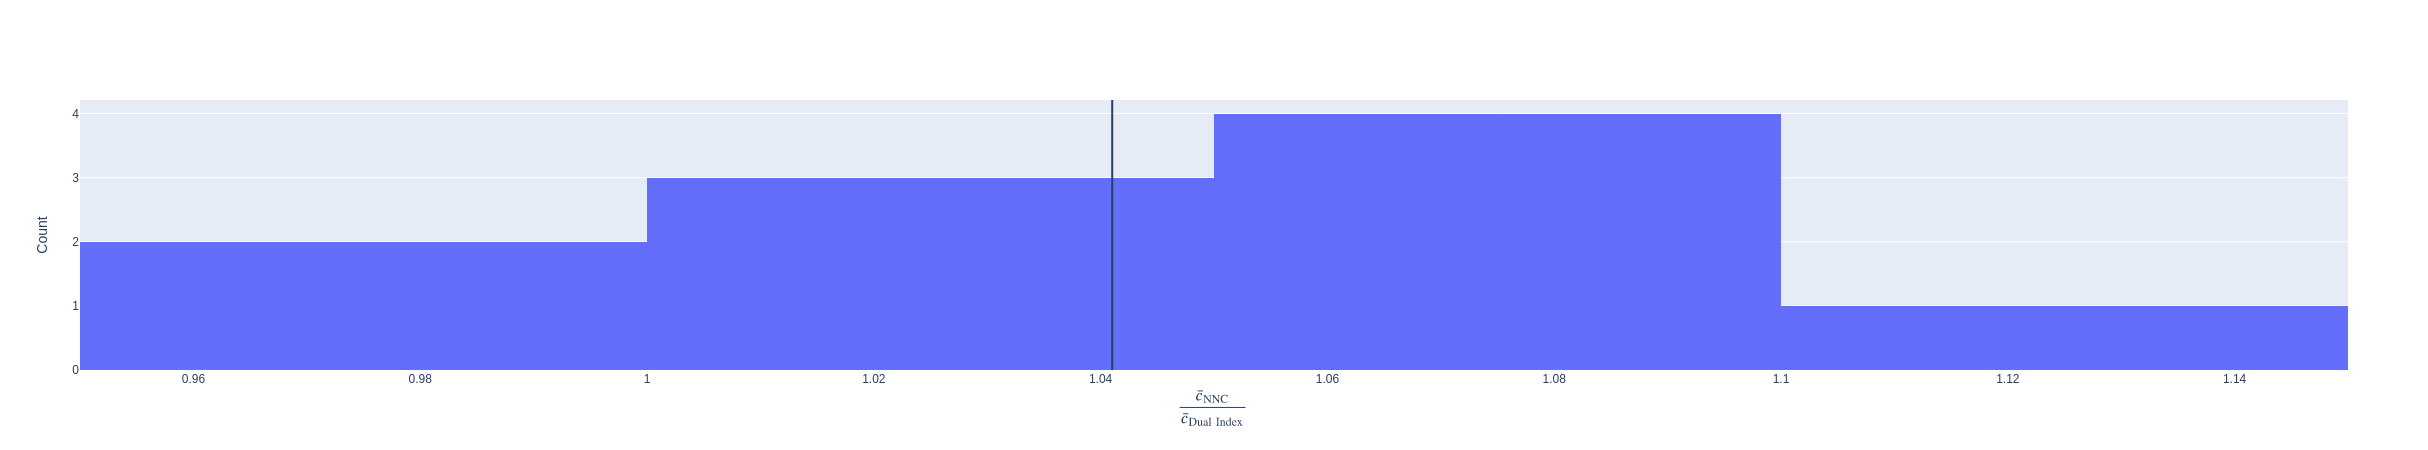

In [338]:
fig = go.Figure(go.Histogram(x=cost_ratios))
fig.add_vline(x=np.mean(cost_ratios))
fig.layout.xaxis.title = r'$\dfrac{\bar{c}_{\text{NNC}}}{\bar{c}_{\text{Dual Index}}}$'
fig.layout.yaxis.title = 'Count'
fig

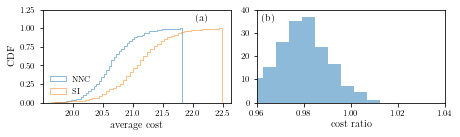

In [20]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 469    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, 0.5*fig_height]
rcParams.update({'figure.figsize': fig_size})

np.savetxt("nnc_cdi_samples_lr=4_ce=10_2.dat",np.c_[cost_nn,cost_cdi])

fig, ax = plt.subplots(ncols=2)
ax[0].text(0.02*(24-22)+22,0.88*1.25,r"(a)")
ax[0].hist(cost_nn,alpha=0.5,bins=50,density=True,label=r"NNC",histtype='step',cumulative=True)
ax[0].hist(cost_cdi,alpha=0.5,bins=50,density=True,label=r"SI",histtype='step',cumulative=True)
#ax[0].set_xlim(22,24)
ax[0].set_ylim(0,1.25)
ax[0].set_xlabel(r"average cost")
ax[0].set_ylabel(r"CDF")
ax[0].legend(loc=3,fontsize=8,frameon=False)

ax[1].text(0.02*(1.04-0.96)+0.96,0.88*40,r"(b)")
ax[1].hist(cost_ratios,bins=12,alpha=0.5,density=True)
ax[1].set_xlim(0.96,1.04)
ax[1].set_ylim(0,40)
ax[1].set_xlabel(r"cost ratio")

plt.tight_layout()
plt.margins(0,0)
plt.savefig("cost_comparison_capped_dual_index.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()


## Single sample comparison
Now we compare the 2 models on a single random sample from the above to examine the difference between NNC and DI control trajectories.

In [381]:
fixed_demands = state_trajectories[1, 1:, 1].unsqueeze(-1)
nn_inv, nn_qr, nn_qe, nn_ci, nn_mean_cost = evaluate_nnc_on_sample(state_trajectories, 22)
cdi_inv, cdi_qr, cdi_qe, cdi_ci, cdi_mean_cost = evaluate_cdi_on_sample(state_trajectories, qr_trajectories, qe_trajectories, 22)

In [383]:
a = go.Scatter(y=[x.item() for x in nn_qr[1:]], name='NNC')
b = go.Scatter(y=cdi_qr, name='SI')
fig = go.Figure([a,b])
fig.layout.xaxis.title = 'Timestep'
fig.layout.yaxis.title = 'Regular Order'
fig

In [384]:
a = go.Scatter(y=[x.item() for x in nn_qe[1:]], name='NNC')
b = go.Scatter(y=cdi_qe, name='SI')
fig = go.Figure([a,b])
fig.layout.xaxis.title = 'Timestep'
fig.layout.yaxis.title = 'Expedited Order'
fig

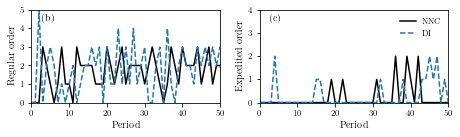

In [35]:
fig, ax = plt.subplots(ncols=2)
ax[0].text(0.05*50,0.88*5,r"(b)")
ax[0].plot([x.item() for x in nn_qr],color="k")
ax[0].plot(di_qr,ls="--")
ax[0].set_xlim(0,50)
ax[0].set_ylim(0,5)
ax[0].set_xlabel(r"Period")
ax[0].set_ylabel(r"Regular order")

ax[1].text(0.05*50,0.88*4,r"(c)")
ax[1].plot([x.item() for x in nn_qe],color="k",label=r"NNC")
ax[1].plot(di_qe,label=r"DI",ls="--")
ax[1].set_xlim(0,50)
ax[1].set_ylim(0,4)
ax[1].set_xlabel(r"Period")
ax[1].set_ylabel(r"Expedited order")
ax[1].legend(loc=1,fontsize=8,frameon=False)

plt.tight_layout()
plt.margins(0,0)
plt.savefig("qrqe_comparison_dual_index.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

In [375]:
a = go.Scatter(y=[x.item() for x in nn_ci], name='NNC')
b = go.Scatter(y=[x.item() for x in cdi_ci], name='CDI')
fig = go.Figure([a,b])
fig.add_hline(nn_mean_cost.detach().item())
fig.add_hline(cdi_mean_cost.detach().item(),line={'dash':'dash'})
fig.layout.xaxis.title = 'Timestep'
fig.layout.yaxis.title = 'Cost'
fig

In [386]:
a = go.Scatter(y=nn_inv, name='NNC Inventory')
b = go.Scatter(y=cdi_inv, name='SI Inventory')
c = go.Scatter(y=[x.detach().item() for x in fixed_demands], name='Demand',
               x=torch.arange(1, 1001).tolist() )
fig = go.Figure([a,b, c])
fig.layout.xaxis.title = 'Timestep'
fig.layout.yaxis.title = 'Quantity'
fig


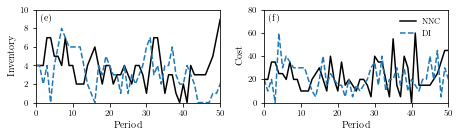

In [37]:
fig, ax = plt.subplots(ncols=2)
ax[0].text(0.02*50,0.88*10,r"(e)")
ax[0].plot(nn_inv,color="k")
ax[0].plot(di_inv,ls="--")
ax[0].set_xlim(0,50)
ax[0].set_ylim(0,10)
ax[0].set_xlabel(r"Period")
ax[0].set_ylabel(r"Inventory")

ax[1].text(0.02*50,0.88*80,r"(f)")
ax[1].plot([x.item() for x in nn_ci],color="k",label=r"NNC")
ax[1].plot([x.item() for x in di_ci],label=r"DI",ls="--")
ax[1].set_xlim(0,50)
ax[1].set_ylim(0,80)
ax[1].set_xlabel(r"Period")
ax[1].set_ylabel(r"Cost")
ax[1].legend(loc=1,fontsize=8,frameon=False)

plt.tight_layout()
plt.margins(0,0)
plt.savefig("inventory_cost_comparison_dual_index.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

We observe that both methods have similar control outputs.